# Practice 1
**Author: Jorge Vázquez Pérez**

## Table of Contents

1. [Preprocessing](#apartado1)
2. [Develop a classical neural network to predict class of each image](#apartado2)
3. [Regularization](#apartado3)
4. [Results](#apartado4)
5. [Conclusions](#apartado5)

We start by loading the datase of fashion MNIST.

In [1]:
%%capture
from tensorflow.keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data();

2023-11-28 13:33:01.052526: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-28 13:33:01.091989: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-28 13:33:01.092028: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-28 13:33:01.092981: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-28 13:33:01.098278: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-28 13:33:01.099286: I tensorflow/core/platform/cpu_feature_guard.cc:1

It can efectively be seen that we are working with a dataset of 64x64 images in a gray scale.

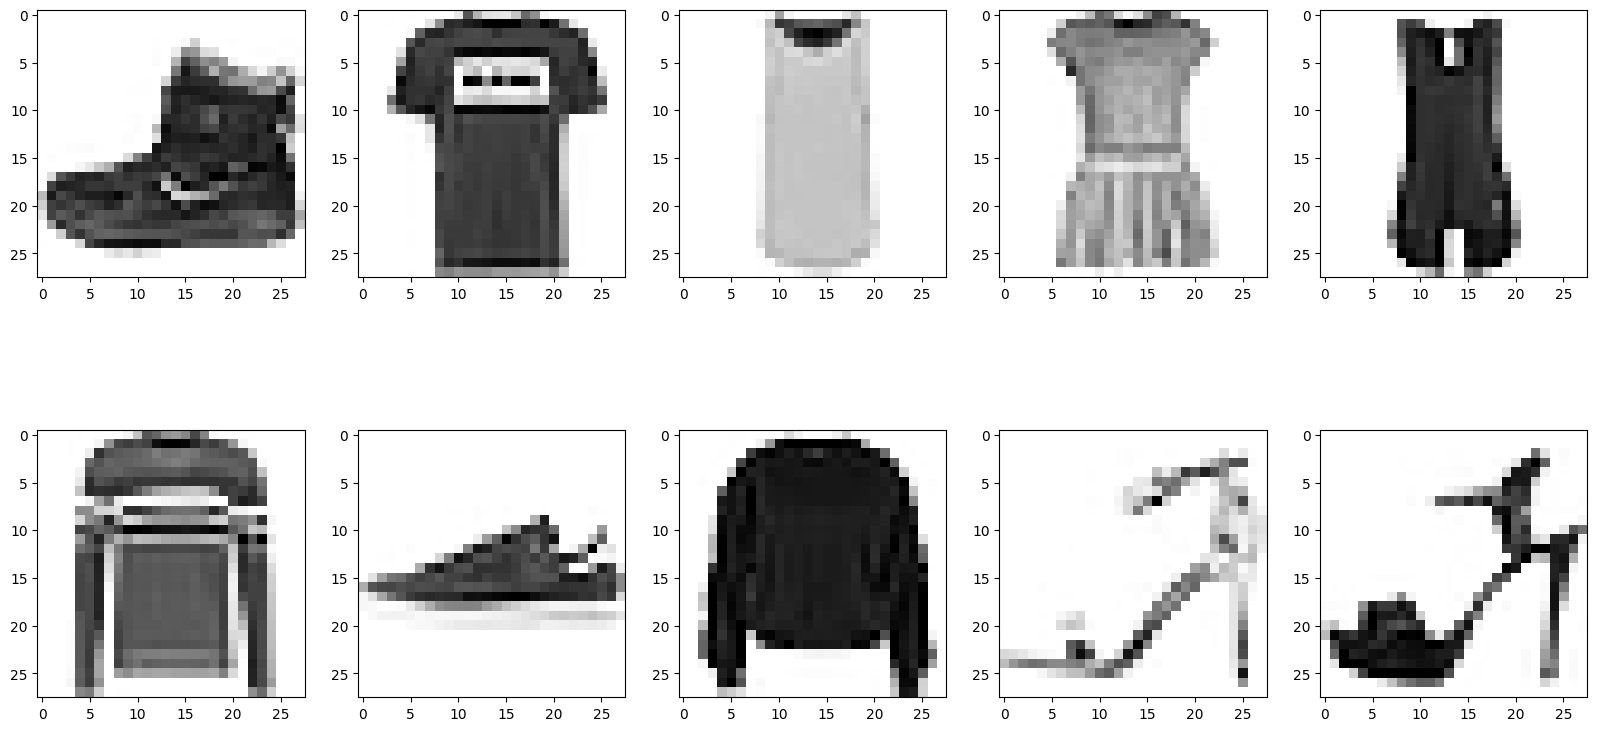

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'Greys'
plt.figure(figsize=(20,10))
ncols = 5
nrows = 2
for i, image in enumerate(x_train[:nrows*ncols]):
    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(image)

And the tags for the shown images correctly correspong to the tags we expected.

In [3]:
print("The tags for the previous images are:")
for i in range(nrows):
    print(y_train[i*ncols:(i+1)*ncols])

The tags for the previous images are:
[9 0 0 3 0]
[2 7 2 5 5]


## Preprocessing <a class="anchor" id="apartado1"></a>

Now that the dataset is correctly load into the notebook we can advance to the preprocessing of the data. As we expected, the shape of the images is the following.

In [4]:
print("Shape of image train set is: ", x_train.shape)
print("Shape of image test set is: ", x_test.shape)

Shape of image train set is:  (60000, 28, 28)
Shape of image test set is:  (10000, 28, 28)


And so we will flatten the image to have a linear array shape in order to introduce the values into the NN. Moreover, we also transform the value of each pixel from a integer ranging from 0 to 255 to a float of 32 bits ranging from 0 to 1. This is due to several reasons including numerical stability, faster convergence, better weight initialization...

In [5]:
x_train = x_train.reshape((60000, 28 * 28))
x_train = x_train.astype('float32') / 255

x_test = x_test.reshape((10000, 28 * 28))
x_test = x_test.astype('float32') / 255

print("Shape of image train set is: ", x_train.shape)
print("Shape of image test set is: ", x_test.shape)

Shape of image train set is:  (60000, 784)
Shape of image test set is:  (10000, 784)


Regarding the tags, we transform them to a binary vector in order to ensure uniqueness, prevente ordinal assumptions and facilitate model integration and interpretation. This utility becomes clearer when working with non-numerical categories.

In [6]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

And last, but not least, we take a subset of the training set for validation. In this case we are not going to use the k-fold cross-validation method. That's because Fashion MNIST is already quite big and diverse, so splitting it into k subsets for testing will take up time and computer power with little reward. We will take the simpler approach: just splitting the data into two sets, 80% for training and 20% for validation (more or less).

In [7]:
x_val = x_train[:10000] # Copy of x_train from the begining (0) to 9999
x_train = x_train[10000:] # Copy of x_train from 10000 to the end
y_val = y_train[:10000]
y_train = y_train[10000:]

## Develop a classical neural network to predict class of each image <a class="anchor" id="apartado2"></a>

First we will define a function to plot different models and compare.

In [8]:
def compare_models(histories):
    fig, axs = plt.subplots(1, 3, figsize=(18, 4))
    for i, history in enumerate(histories):
        history_dict = history.history
        epochs = range(1, len(history_dict['loss']) + 1)
        axs[i].plot(epochs, history_dict['loss'], 'b-o', label='Training loss')
        axs[i].plot(epochs, history_dict['val_loss'], 'r-o', label='Validation loss')
        axs[i].set_title('Model {}'.format(i+1))
        axs[i].set_xlabel('Epochs')
        axs[i].set_ylabel('Loss')
        axs[i].legend()
    
    # Display the plot
    plt.tight_layout()
    plt.show()

### Structural hyperparameters

Now, we move into the structure of the NN. In this section we will decide three main aspects: number of hidden layers, number of neurons per layer and the activation function of the neurons. Of course, this is a truly difficult challenge in the sense that the conbinations are numerous and no optimal solution exists. The directives that we are going to follow are the next ones:

- Minumum resources.
- Minimum overfitting.
- Validation loss minimality.

These are the three points of argumention that we are going to tackle in order to decide the structure of the NN. Of course the search space is enourmous, so when trying to guess the value of a hyperparameter we will freeze the value of the other two in order to see how that hyperparameter alone modify the results. Let's start with number of hidden layers.

2023-11-28 13:33:13.831303: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Training different models to compare... Done.


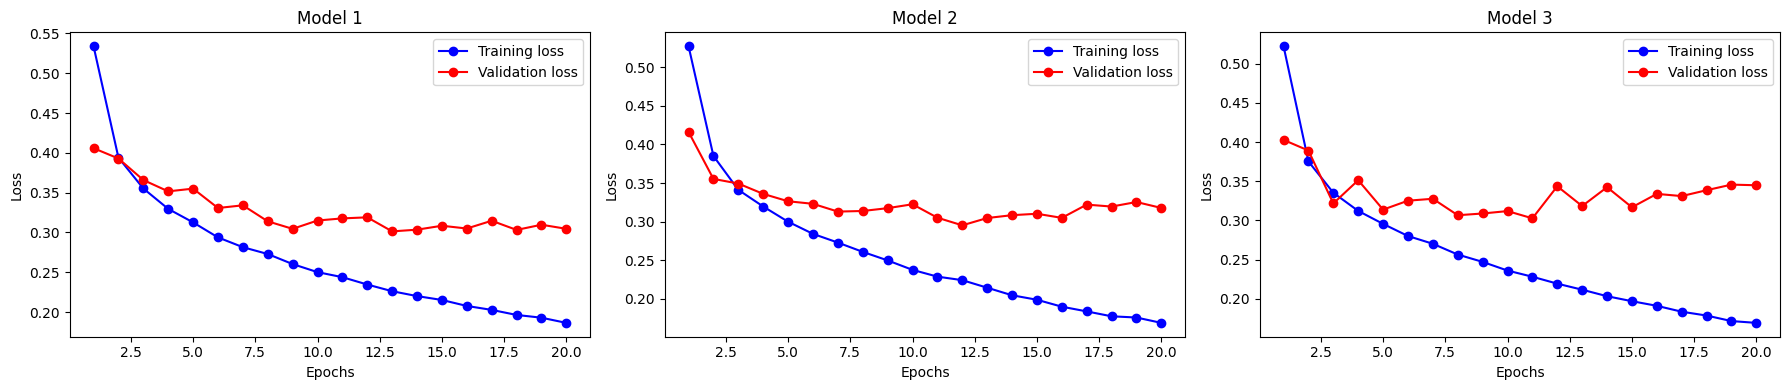

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Define the model
model1 = Sequential([
    Flatten(input_shape=(784,)),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')  # Output layer for 10 classes
])

# Define the model
model2 = Sequential([
    Flatten(input_shape=(784,)),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')  # Output layer for 10 classes
])

# Define the model
model3 = Sequential([
    Flatten(input_shape=(784,)),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')  # Output layer for 10 classes
])

for model in [model1, model2, model3]:
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

print("Training different models to compare...", end=" ")
history1 = model1.fit(x_train, y_train, epochs = 20, batch_size = 64, validation_data = (x_val, y_val), verbose=0)
history2 = model2.fit(x_train, y_train, epochs = 20, batch_size = 64, validation_data = (x_val, y_val), verbose=0)
history3 = model3.fit(x_train, y_train, epochs = 20, batch_size = 64, validation_data = (x_val, y_val), verbose=0)
print("Done.")

compare_models([history1, history2, history3])

In this case we see that the validation loss stays around 0.3 in every case, which already points us in the direction to choose only one layer in order to minimize the resources utilized. But, also, the fact that the training loss decreases in the two last models indicate us the increasing in the overfitting of the model due to the non-improvement of the validation loss. This is why, from now on, our model will be composed by only one hidden layer.

We move now to the number of nuerons per layer.

Training different models to compare... Done.


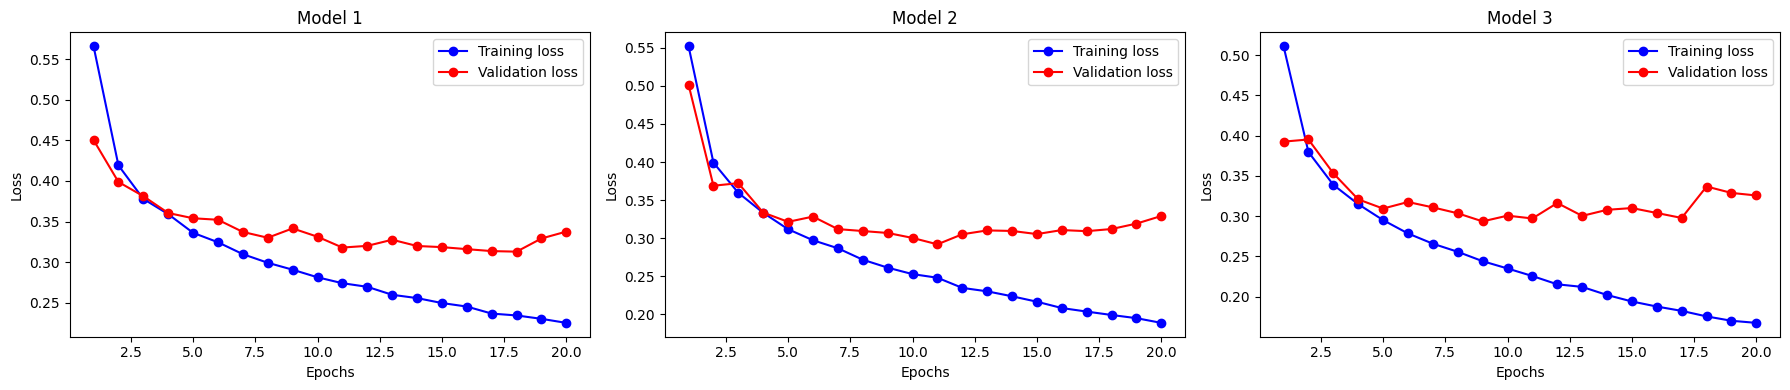

In [10]:
# Define the model
model1_ = Sequential([
    Flatten(input_shape=(784,)),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')  # Output layer for 10 classes
])

# Define the model
model2_ = Sequential([
    Flatten(input_shape=(784,)),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')  # Output layer for 10 classes
])

# Define the model
model3_ = Sequential([
    Flatten(input_shape=(784,)),
    Dense(256, activation='relu'),
    Dense(10, activation='softmax')  # Output layer for 10 classes
])

for model in [model1_, model2_, model3_]:
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

print("Training different models to compare...", end=" ")
history1_ = model1_.fit(x_train, y_train, epochs = 20, batch_size = 64, validation_data = (x_val, y_val), verbose=0)
history2_ = model2_.fit(x_train, y_train, epochs = 20, batch_size = 64, validation_data = (x_val, y_val), verbose=0)
history3_ = model3_.fit(x_train, y_train, epochs = 20, batch_size = 64, validation_data = (x_val, y_val), verbose=0)
print("Done.")

compare_models([history1_, history2_, history3_])

Again, the third model suffers from overfitting because of the little improvement achieved in the validation set in comparison to the one obtained in the training set. Between the first and the second a dificult decision has to be made because, althought in this case the overfitting of the second model does not seem so critical as in the third one, the number of neurons is doubled and so the resources are highly increased. A point can be made in terms of the improvement made by the second model in the validation loss, but is it enough to duplicate the resources? In this case we will evaluate the models agaist the test set in order to make a final decision.

In [11]:
results = model1_.evaluate(x_test, y_test)
print(results)
results = model2_.evaluate(x_test, y_test)
print(results)

313/313 [==============================] - 0s 2ms/step - loss: 0.3708 - accuracy: 0.8711
[0.3707832396030426, 0.8711000084877014]
313/313 [==============================] - 1s 2ms/step - loss: 0.3641 - accuracy: 0.8780
[0.3640825152397156, 0.878000020980835]


And we see that the loss and accuracy are almost identical in both cases so the numbers of neurons will be from now on 64 due to the lack of improvement and the aditional cost of resources of the second model.

We move now to the final structural hyperparameter. We will compare four activation functions.

In [12]:
# List of activation functions to compare.
activation_functions = ['relu', 'sigmoid', 'tanh', 'softmax']

# Dictionary to store results.
results = {}

for activation in activation_functions:
    # Create a Sequential model.
    model = Sequential([
        Flatten(input_shape=(784,)),
        Dense(64, activation=activation),
        Dense(10, activation='softmax')
    ])

    # Compile the model.
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model.
    print(f"\nTraining model with {activation} activation...", end=" ")
    history = model.fit(x_train, y_train, batch_size = 64, validation_data=(x_val, y_val), epochs=20, verbose=0)
    print(f"Done.")
    
    # Evaluate the model.
    score = model.evaluate(x_test, y_test, verbose=0)
    results[activation] = score[1]  # store the accuracy

# Print the results.
print(f"------ Activation results --------\n\n")
for activation, accuracy in results.items():
    print(f"Accuracy with {activation} activation: {accuracy:.4f}")


Training model with relu activation... Done.

Training model with sigmoid activation... Done.

Training model with tanh activation... Done.

Training model with softmax activation... Done.
------ Activation results --------


Accuracy with relu activation: 0.8765
Accuracy with sigmoid activation: 0.8825
Accuracy with tanh activation: 0.8711
Accuracy with softmax activation: 0.8140


Looking at the accuracies, the decision falls between ReLU and sigmoid. We will choose ReLU despite having a little less accuracy than sigmoid for two reasons: its simplicity and its addressing of the vanishing gradient problem.

### Learning parameters

Now, when talking about learning parameters the number of them increases with respect to structural parameters: optimizer, learning rate, epochs, batch size and metrics are the ones that we are going to address.

In this case, instead of manually 

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from keras_tuner import HyperModel
from keras_tuner.tuners import GridSearch

class MyHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential([
            Flatten(input_shape=(784,)),
            Dense(64, activation='relu'),
            Dense(10, activation='softmax')
        ])
    
        # Hyperparameters to tune
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        hp_optimizer = hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop'])
        hp_metric = hp.Choice('metrics', values=['accuracy', 'precision', 'recall'])
    
        # Choose the optimizer
        if hp_optimizer == 'adam':
            optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
        elif hp_optimizer == 'sgd':
            optimizer = tf.keras.optimizers.SGD(learning_rate=hp_learning_rate)
        else:
            optimizer = tf.keras.optimizers.RMSprop(learning_rate=hp_learning_rate)
    
        model.compile(optimizer=optimizer,
                      loss='categorical_crossentropy',
                      metrics=hp_metric)
    
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            epochs=hp.Choice("epochs", [15, 20, 25]),
            batch_size=hp.Choice("batch_size", [32, 64, 168]),
            **kwargs,
        )    

# Create a BayesianOptimization tuner
tuner = GridSearch(
    MyHyperModel(),
    objective='val_accuracy',
    max_trials=5
)

# Perform the hyperparameter search
tuner.search(x_train, y_train,
             validation_data=(x_val, y_val))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=5)[0]

optimizer = best_hps.get('optimizer')
learning_rate = best_hps.get('learning_rate')
metric = best_hps.get('metrics')
batch_size = best_hps.get('batch_size')
epochs = best_hps.get('epochs')

print(f""" The hyperparameter search is complete.
- Best optimizer: {optimizer}.
- Best learning rate: {learning_rate}.
- Best metric: {metric}.
- Best batch size: {batch_size}.
- Best epochs: {epochs}.
""")


# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)

print("\nTraining the final model...", end=" ")
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val), verbose = 0)
print("Done.")


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
0.01              |0.01              |learning_rate
adam              |adam              |optimizer
accuracy          |accuracy          |metrics

Epoch 1/15
1563/1563 [==============================] - 5s 3ms/step - loss: 0.5270 - accuracy: 0.8137 - val_loss: 0.4686 - val_accuracy: 0.8342
Epoch 2/15
1563/1563 [==============================] - 4s 3ms/step - loss: 0.4394 - accuracy: 0.8414 - val_loss: 0.5064 - val_accuracy: 0.8317
Epoch 3/15
1563/1563 [==============================] - 4s 2ms/step - loss: 0.4198 - accuracy: 0.8491 - val_loss: 0.4574 - val_accuracy: 0.8410
Epoch 4/15
1563/1563 [==============================] - 4s 2ms/step - loss: 0.4044 - accuracy: 0.8543 - val_loss: 0.4716 - val_accuracy: 0.8365
Epoch 5/15
1563/1563 [==============================] - 4s 3ms/step - loss: 0.3966 - accuracy: 0.8560 - val_loss: 0.4574 - val_accuracy: 0.8466
Epoch 6/15
1563/1563 [==============================]

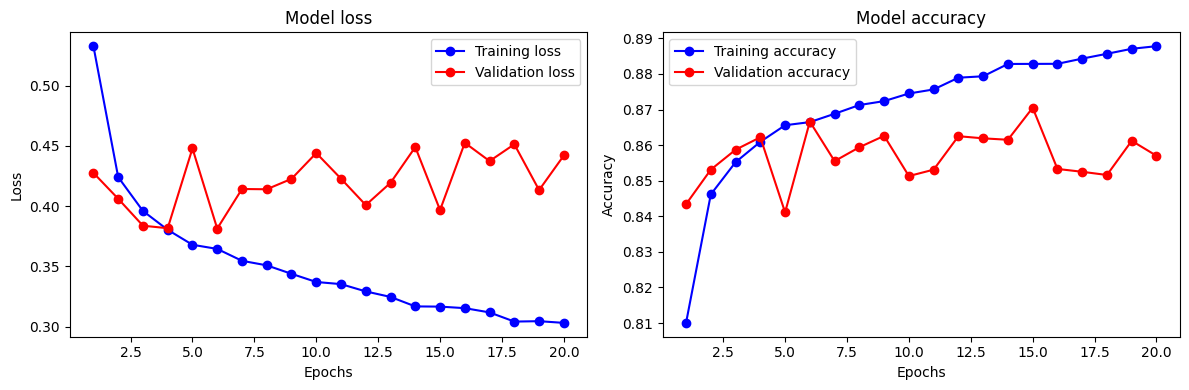

In [15]:
import matplotlib.pyplot as plt

def show_accloss(specific_history):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    history_dict = specific_history.history
    epochs = range(1, len(history_dict['loss']) + 1)
    
    # Loss
    axs[0].plot(epochs, history_dict['loss'], 'b-o', label='Training loss')
    axs[0].plot(epochs, history_dict['val_loss'], 'r-o', label='Validation loss')
    axs[0].set_title('Model loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    
    #Accuracy
    axs[1].plot(epochs, history_dict['accuracy'], 'b-o', label='Training accuracy')
    axs[1].plot(epochs, history_dict['val_accuracy'], 'r-o', label='Validation accuracy')
    axs[1].set_title('Model accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    
    # Display the plot
    plt.tight_layout()
    plt.show()

show_accloss(history)

In [16]:
results = model.evaluate(x_test, y_test)
print(results)

313/313 [==============================] - 1s 2ms/step - loss: 0.4755 - accuracy: 0.8489
[0.47554072737693787, 0.8489000201225281]


## Regularization <a class="anchor" id="apartado3"></a>

In [ ]:
from tensorflow.keras.layers import Dropout

model = Sequential([
    Flatten(input_shape=(784,)),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(10, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=metric)

history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val), verbose = 0)

In [ ]:
show_accloss(history)

In [ ]:
results = model.evaluate(x_test, y_test)
print(results)

In [ ]:
from tensorflow.keras.layers import BatchNormalization

model = Sequential([
    Flatten(input_shape=(784,)),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(10, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=metric)

history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val))

In [ ]:
show_accloss(history)

In [ ]:
results = model.evaluate(x_test, y_test)
print(results)

In [ ]:
from tensorflow.keras import regularizers

model = Sequential([
    Flatten(input_shape=(784,)),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(10, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=metric)

history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val))

In [ ]:
show_accloss(history)

In [ ]:
results = model.evaluate(x_test, y_test)
print(results)

## Results <a class="anchor" id="apartado4"></a>

## Conclusions <a class="anchor" id="apartado5"></a>